In [11]:
# Install required packages
!pip3 install beautifulsoup4
!pip3 install requests

# Import libraries
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

# Helper functions (provided in the notebook)
def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out=''.join([booster_version for i,booster_version in enumerate(table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    out=[i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass

def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
    colunm_name = ' '.join(row.contents)
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

# TASK 1: Request the Falcon9 Launch Wiki page
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Verify page title
print(soup.title.string)

# TASK 2: Extract column names
html_tables = soup.find_all('table', {"class": "wikitable plainrowheaders collapsible"})
first_launch_table = html_tables[2]

# Extract and clean column headers
column_names = []
headers = first_launch_table.find_all('th')
for header in headers:
    name = extract_column_from_header(header)
    if name and (name not in column_names) and len(name) > 0:
        column_names.append(name)

print("Extracted Columns:", column_names)

# TASK 3: Parse launch records
launch_dict = {
    'Flight No.': [],
    'Launch site': [],
    'Payload': [],
    'Payload mass': [],
    'Orbit': [],
    'Customer': [],
    'Launch outcome': [],
    'Version Booster': [],
    'Booster landing': [],
    'Date': [],
    'Time': []
}

# Iterate through all relevant tables (table index 2 onwards)
for table in html_tables[2:]:
    rows = table.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        # Check if row contains launch data (has 9 cells)
        if len(cells) == 9:
            flight_number = row.th.get_text(strip=True) if row.th else "N/A"
            
            # Extract data using helper functions
            date, time = date_time(cells[0]) if cells[0].string else ("N/A", "N/A")
            bv = booster_version(cells[1]) if cells[1] else "N/A"
            launch_site = cells[2].a.get_text(strip=True) if cells[2].a else "N/A"
            payload = cells[3].a.get_text(strip=True) if cells[3].a else "N/A"
            payload_mass = get_mass(cells[4])
            orbit = cells[5].a.get_text(strip=True) if cells[5].a else "N/A"
            customer = cells[6].a.get_text(strip=True) if cells[6].a else "N/A"
            launch_outcome = cells[7].get_text(strip=True)
            booster_landing = landing_status(cells[8])
            
            # Append data to dictionary
            launch_dict['Flight No.'].append(flight_number)
            launch_dict['Date'].append(date)
            launch_dict['Time'].append(time)
            launch_dict['Version Booster'].append(bv)
            launch_dict['Launch site'].append(launch_site)
            launch_dict['Payload'].append(payload)
            launch_dict['Payload mass'].append(payload_mass)
            launch_dict['Orbit'].append(orbit)
            launch_dict['Customer'].append(customer)
            launch_dict['Launch outcome'].append(launch_outcome)
            launch_dict['Booster landing'].append(booster_landing)

# Create DataFrame
spacex_df = pd.DataFrame(launch_dict)
print(f"Scraped {len(spacex_df)} records")

# Export to CSV
spacex_df.to_csv('spacex_web_scraped.csv', index=False)
print("Data saved to spacex_web_scraped.csv")

List of Falcon 9 and Falcon Heavy launches - Wikipedia
Extracted Columns: ['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']
Scraped 112 records
Data saved to spacex_web_scraped.csv


/var/folders/54/8p1pzd9s4nz5651vsnlrbfv40000gn/T/ipykernel_48365/1068772645.py:145: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/54/8p1pzd9s4nz5651vsnlrbfv40000gn/T/ipykernel_48365/1068772645.py:146: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.savefig('spacex_web_scraping_flowchart.png', dpi=300, bbox_inches='tight')
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


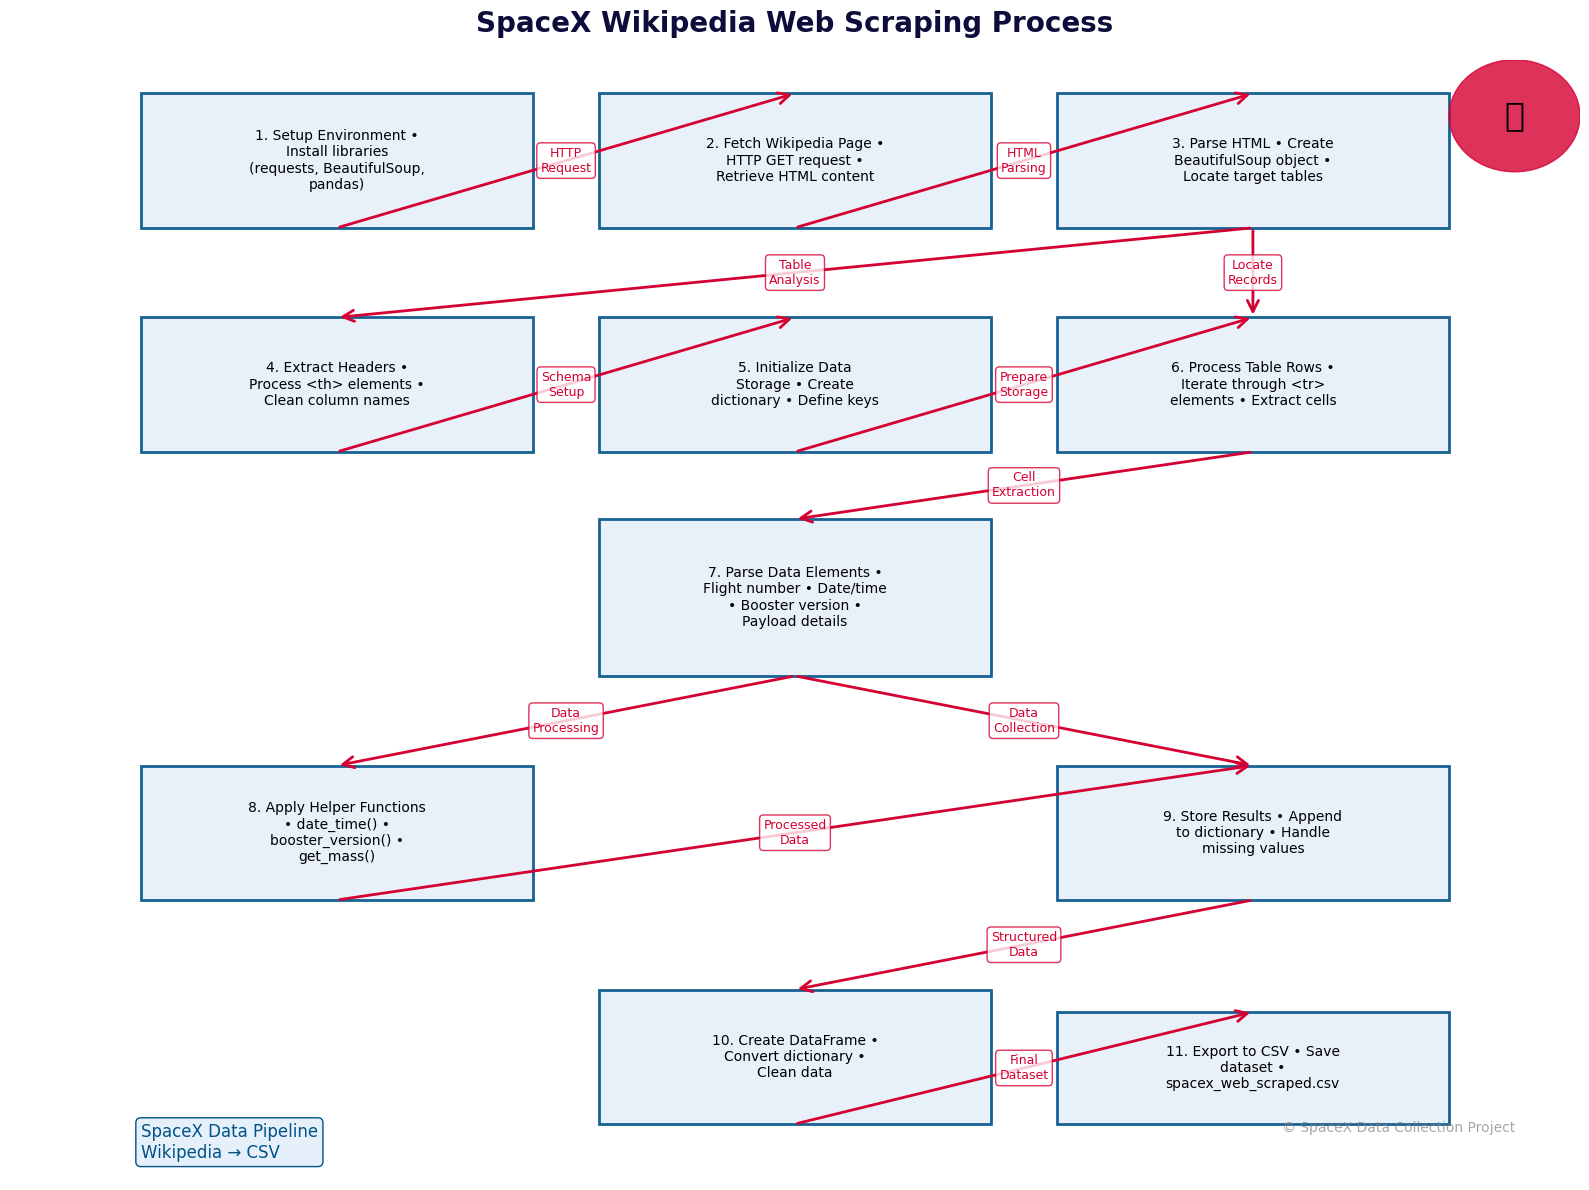

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle
import matplotlib.patheffects as path_effects
import textwrap

# Create flowchart
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
plt.title('SpaceX Wikipedia Web Scraping Process', 
          fontsize=20, weight='bold', pad=20, 
          color='#0d0d3b',  # SpaceX dark blue
          fontfamily='sans-serif')

# Colors
SPACEX_BLUE = '#005288'
SPACEX_RED = '#d50032'
LIGHT_BLUE = '#e6f0fa'

# Helper function to create boxes
def create_box(x, y, width, height, label, color=SPACEX_BLUE):
    box = Rectangle((x, y), width, height, 
                    fill=True, facecolor=LIGHT_BLUE, 
                    edgecolor=color, lw=2, 
                    alpha=0.9, linestyle='-')
    ax.add_patch(box)
    
    # Add text with wrapping
    wrapped = textwrap.fill(label, width=25)
    ax.text(x + width/2, y + height/2, wrapped, 
            ha='center', va='center', 
            fontsize=10, fontfamily='sans-serif')
    return box

# Steps
steps = [
    (1, "1. Setup Environment\n• Install libraries\n(requests, BeautifulSoup, pandas)",
     1.0, 8.5, 3.0, 1.2),
    (2, "2. Fetch Wikipedia Page\n• HTTP GET request\n• Retrieve HTML content",
     4.5, 8.5, 3.0, 1.2),
    (3, "3. Parse HTML\n• Create BeautifulSoup object\n• Locate target tables",
     8.0, 8.5, 3.0, 1.2),
    (4, "4. Extract Headers\n• Process <th> elements\n• Clean column names",
     1.0, 6.5, 3.0, 1.2),
    (5, "5. Initialize Data Storage\n• Create dictionary\n• Define keys",
     4.5, 6.5, 3.0, 1.2),
    (6, "6. Process Table Rows\n• Iterate through <tr> elements\n• Extract cells",
     8.0, 6.5, 3.0, 1.2),
    (7, "7. Parse Data Elements\n• Flight number\n• Date/time\n• Booster version\n• Payload details",
     4.5, 4.5, 3.0, 1.4),
    (8, "8. Apply Helper Functions\n• date_time()\n• booster_version()\n• get_mass()",
     1.0, 2.5, 3.0, 1.2),
    (9, "9. Store Results\n• Append to dictionary\n• Handle missing values",
     8.0, 2.5, 3.0, 1.2),
    (10, "10. Create DataFrame\n• Convert dictionary\n• Clean data",
     4.5, 0.5, 3.0, 1.2),
    (11, "11. Export to CSV\n• Save dataset\n• spacex_web_scraped.csv",
     8.0, 0.5, 3.0, 1.0)
]

# Create all boxes
boxes = {}
for step in steps:
    num, label, x, y, w, h = step
    box = create_box(x, y, w, h, label)
    boxes[num] = box

# Add arrows
arrows = [
    (1, 2, "HTTP\nRequest"),
    (2, 3, "HTML\nParsing"),
    (3, 4, "Table\nAnalysis"),
    (3, 6, "Locate\nRecords"),
    (4, 5, "Schema\nSetup"),
    (5, 6, "Prepare\nStorage"),
    (6, 7, "Cell\nExtraction"),
    (7, 8, "Data\nProcessing"),
    (7, 9, "Data\nCollection"),
    (8, 9, "Processed\nData"),
    (9, 10, "Structured\nData"),
    (10, 11, "Final\nDataset")
]

# Draw arrows with SpaceX colors
def draw_arrow(start, end, label=None, color=SPACEX_RED):
    start_box = boxes[start]
    end_box = boxes[end]
    
    # Calculate positions
    start_x = start_box.get_x() + start_box.get_width()/2
    start_y = start_box.get_y()
    end_x = end_box.get_x() + end_box.get_width()/2
    end_y = end_box.get_y() + end_box.get_height()
    
    # Adjust positions for layout
    if start == 3 and end == 4:  # Special case
        end_y = end_box.get_y() + end_box.get_height()
    
    arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                            arrowstyle='->', 
                            mutation_scale=20, 
                            color=color,
                            linewidth=2)
    ax.add_patch(arrow)
    
    if label:
        # Position label at arrow midpoint
        label_x = (start_x + end_x) / 2
        label_y = (start_y + end_y) / 2
        ax.text(label_x, label_y, label, 
                ha='center', va='center', 
                backgroundcolor='white',
                fontsize=9, color=color,
                bbox=dict(boxstyle="round,pad=0.3", 
                          facecolor='white', 
                          edgecolor=color, 
                          alpha=0.8))

# Draw all arrows
for arrow in arrows:
    draw_arrow(*arrow)

# Add SpaceX Falcon 9 icon
falcon_icon = plt.Circle((11.5, 9.5), 0.5, color=SPACEX_RED, alpha=0.8)
ax.add_patch(falcon_icon)
ax.text(11.5, 9.5, "🚀", 
        fontsize=24, ha='center', va='center')

# Add legend
legend_text = "SpaceX Data Pipeline\nWikipedia → CSV"
ax.text(1.0, 0.2, legend_text, 
        fontsize=12, color=SPACEX_BLUE,
        bbox=dict(boxstyle="round", 
                  facecolor=LIGHT_BLUE, 
                  edgecolor=SPACEX_BLUE))

# Add watermark
fig.text(0.95, 0.05, "© SpaceX Data Collection Project", 
         ha='right', va='bottom', 
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig('spacex_web_scraping_flowchart.png', dpi=300, bbox_inches='tight')
plt.show()